In [1]:
import pickle
from os.path import exists 
import pandas as pd
import plotly.express as px
from feature_engine.selection import DropCorrelatedFeatures
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_evaluations, plot_convergence, plot_objective
from skopt.utils import dump, load

from utils.data_preparation import *
from utils.data_exploration import *
from utils.training import *

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


task = "cyp1a2"

# Data

## Molecular Fingerprints

Machine learning models almost always take arrays of numbers as their inputs. If we want to process molecules with them, we somehow need to represent each molecule as one or more arrays of numbers.

Many (but not all) types of models require their inputs to have a fixed size. This can be a challenge for molecules, since different molecules have different numbers of atoms. If we want to use these types of models, we somehow need to represent variable sized molecules with fixed sized arrays.

Fingerprints are designed to address these problems. A fingerprint is a fixed length array, where different elements indicate the presence of different features in the molecule. If two molecules have similar fingerprints, that indicates they contain many of the same features, and therefore will likely have similar chemistry.

RDKit supports a particular type of fingerprint called an "Extended Connectivity Fingerprint", or "ECFP" for short. They also are sometimes called "circular fingerprints". The ECFP algorithm begins by classifying atoms based only on their direct properties and bonds. Each unique pattern is a feature. For example, "carbon atom bonded to two hydrogens and two heavy atoms" would be a feature, and a particular element of the fingerprint is set to 1 for any molecule that contains that feature. It then iteratively identifies new features by looking at larger circular neighborhoods. One specific feature bonded to two other specific features becomes a higher level feature, and the corresponding element is set for any molecule that contains it. This continues for a fixed number of iterations, most often two.

source: [https://www.kaggle.com/code/shivanshuman/molecular-fingerprints]

## Loading the Dataset + Data Cleaning

In terms of data cleaning the following steps are performed:

- Normalization of smiles strings before calculating descriptors and fingerprints
  - Normalization includes the removal of metals in the molecule (<span style="color:cyan">TODO</span> Why?)
- Removal of small molecules
  - For example: 
    - Molecules consisting of a single atom (<span style="color:cyan">TODO</span> Why?)
    - Molecules that are metals
- Removing of NaN values by either removing the corresponding column or row. 
  - For molecular descriptors it doesn't make much sense to fill missing values with some default value or mean of the existing values


In the first iteration we will focus on using the Morgan fingerprints. If there is time later we will explore other fingerprints and compare. 

In [2]:
data = data_preprocessing(task)
# we only use Morgan fingerprints
data = data.drop(["MACCS_FP", "ATOMPAIR_FP"], axis=1)
data = select_druglike_molecules(data)
# data = remove_small_molecules(data)

# turn string of fingerprints into single features
morgan_fingerprint_df = pd.DataFrame(
    convert_strings_to_int_array(data["Morgan_FP"].values), index=data.index
)
data = data.merge(morgan_fingerprint_df, left_index=True, right_index=True)

data

Dataset already exists, returning data/cyp1a2/raw_dataset.csv.
Numbe of molecules before druglikeliness selection: 12579
Numbe of druglike molecules: 12138


,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,CCCC(=O)Nc1ccc(N2CCN(CC)CC2)c(Cl)c1,6602638.0,11.609395,0.039701,11.609395,0.039701,0.906872,309.841,285.649,...,0,0,0,0,0,0,0,0,0,0
1,1,O=c1[nH]c2cc3c(cc2cc1CN(CCCO)Cc1nnnn1Cc1ccc(F)...,644510.0,13.221898,-0.305076,13.221898,0.022394,0.383547,466.473,443.289,...,0,0,0,0,0,0,0,0,0,0
2,1,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1960010.0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,...,0,0,0,0,0,0,1,0,0,0
3,1,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,644675.0,12.610408,-3.973681,12.610408,0.072387,0.720977,355.418,346.346,...,0,0,0,0,0,0,0,0,0,0
4,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,644851.0,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12574,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,16758815.0,9.674588,-0.801690,9.674588,0.174259,0.635371,210.229,196.117,...,0,0,0,0,0,0,0,0,0,0
12575,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,16758816.0,13.390757,-1.019880,13.390757,0.162294,0.455270,397.427,374.243,...,0,0,0,0,0,0,0,0,0,0
12576,0,CCN1C(=O)[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@...,16758817.0,12.817440,-0.985371,12.817440,0.131139,0.406549,335.356,314.188,...,0,0,0,0,0,0,0,0,0,0
12577,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,16758818.0,13.179767,-1.161112,13.179767,0.077392,0.772281,357.406,334.222,...,0,0,0,0,0,0,0,0,0,0


### Remove missing values 
Since less than 1% of molecules have missing values we simply remove those molecules since using a default value doesn't make much sense for the shown descriptors.

In [3]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data = data.drop(data_nan.index)
print("Data shape after dropping NaN samples:", data.shape)
data_nan

There are 37 (0.30%) molecules and 12 descriptors with missing values.
Data shape after dropping NaN samples: (12101, 2260)


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3783,O=[N+]([O-])c1ccc(C[As](=O)(O)O)cc1,222574.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3807,C[C@@H](O)COc1ccc([As](=O)(O)O)cc1N,3246035.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3814,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3815,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3816,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3817,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3818,O=[As]c1ccc(S(=O)(=O)NCCO)cc1,224336.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3823,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3834,O=[As](O)(O)c1ccc(N=Nc2ccc([As](=O)(O)O)cc2)cc1,23749.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3835,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train-Validation-Test split


In [4]:
# split data in train, val, test
datasets = dataset_split(data.drop(["Drug", "Drug_ID", "Morgan_FP"], axis=1))
# The descriptors include discrete and continuous data, distinguished by their dtype.
feature_groups = get_feature_groups(datasets, morgan_fingerprint_df)

Splitting the data into 70.00% training, 10.00% validation, and 20.00% testing.
Unique Datatypes: {dtype('float64'), dtype('int64')}


# Dataset Exoploration

In [ ]:
#from pandas_profiling import ProfileReport
# import pandas_profiling

#datasets["train"].profile_report( pool_size=1)
#profile = ProfileReport(datasets["train"], pool_size=1)
#profile

In [ ]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP2C19 inhibition",
    kind="pie",
)
datasets["train"].describe()

## Continuous Data

In [ ]:
# Correlation matrix of descriptors
cor_matrix = datasets["train"][feature_groups.continuous].corr()
top_cor_matrix = cor_matrix.where(
    np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation",
)

fig.write_html(f"data/{task}/descriptor_correlation.html")

# violin plots
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.continuous],
    features=feature_groups.continuous[10:14],
    suptitle="Feature distributions given the target label using a KDE",
    task=f"{task} inhibition",
)

## Discrete Data

In [ ]:
feature_distributions(
    data=datasets["train"][["Y"] + feature_groups.discrete],
    features=feature_groups.discrete[5:9],
    kind="hist",
    suptitle="Feature Distributions given the target label",
    task="CYP2C19 inhibition",
)

# Feature Engineering

## Feature Selection

There are in total 208 different descriptors. Relevant descriptors for the task of predicting CYP inhibition need to be selected to reduce the number of input variables to the clasical machine learning algorithm. Feature selection can either be performed unsupervised (without knowledge of the target label) or supervised.

**Note:** Some machine learning models have some form of feature selection inbuild, e.g. tree-based models. In those cases we don't perform feature selection upfront.

### Variance Threshold

Having a look at for example the number of radical electrons (NumRadicalElectrons). We can see that all datapoints in the dataset have a value of 0 (min=max=0.0). 

In the area of feature selection there is a method called **variance threshold**: Given a threshold all features with a variance below this threshold will be removed. (<span style="color:cyan">TODO</span> Add better source; https://medium.com/nerd-for-tech/removing-constant-variables-feature-selection-463e2d6a30d9#:~:text=Variance%20Threshold%20is%20a%20feature,be%20used%20for%20unsupervised%20learning.)

The default value is usually 0 (removing constant features as they obviously bring no additional information to our model). If the variance threshold is greater than zero but still small we are removing quasi-constant features. The arguments against using a variance greater than 0 say that you may be moving variables that, although they have low variance, might actually be extremely powerful in explaining your target (dependent) variable.

For now, we are exploring which features are constant in our dataset.

In [ ]:
print("Features with 0 variance:\n")
for index, n_unique in zip(
    datasets["train"].nunique(axis=0).index, datasets["train"].nunique(axis=0)
):
    if n_unique == 1:
        print(index)
        
print("\n", summarize_descriptors(["NumRadicalElectrons"]))
datasets["train"]["NumRadicalElectrons"].describe()

### Drop Correlated Features

As shown in the correlation matrix there are some feature groups in our dataset with high correlation. In order to escape the curse of dimensionality we want to remove features with a high correlation to other features - out of two features with high correlation only one remains. When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. Source: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

The y-axis of the following dendrogram is a measure of closeness of either individual data points or clusters. 


The idea of dropping highly correlated features is also applied by the following method: [DropCorrelatedFeatures](https://feature-engine.readthedocs.io/en/1.1.x/selection/DropCorrelatedFeatures.html) from the feature_engine. Here, features are removed on first found first removed basis, without any further insight using pearson correlation score.

In [ ]:
plot_dendrogram(cor_matrix, level=7, color_threshold=2)

In [ ]:
# Exploring DropCorrelatedFeatures

drop_corr_features = DropCorrelatedFeatures(threshold=0.8)
print(
    "Number of features before transformation:",
    datasets["train"][feature_groups.continuous].shape[1],
)
reduced_continuous_data = drop_corr_features.fit_transform(
    datasets["train"][feature_groups.continuous]
)
print("Number of features after transformation:", reduced_continuous_data.shape[1])

# Correlation matrix of descriptors
reduced_cor_matrix = reduced_continuous_data.corr()
reduced_top_cor_matrix = reduced_cor_matrix.where(
    np.triu(np.ones(reduced_cor_matrix.shape), k=1).astype(np.bool)
)
fig = px.imshow(
    reduced_top_cor_matrix,
    color_continuous_scale="RdBu_r",
    title=f"{task} inhibition\nDescriptor correlation after dropping highly correlated features",
)

fig.write_html(f"data/{task.lower()}/descriptor_correlation_pruned.html")

    **NOTE:** We don't do the following anymore.

    ### Select Percentile

    For discrete features and fingerprints we are using a mutual information statistical test and apply multivariate feature selection.

    ## Dimensionality reduction

    ### PCA

    For continuous data we will perform a PCA to reduce the dimensionality of the features. Since PCA should only be applied to continuous data we will split our preprocessing pipeline into three parts:

    1. Preprocessing of continuous descriptors
    2. Preprocessing of discrete descriptors
    3. Preprocessing of the fingerprint

    See DataPreprocessing in utils/training.py for the exact preprocessing pipelines.

## Feature Normalization

For continuous features and discrete descriptors we are using a MinMaxScaler. Since fingerprint features are binary we don't normalize them.

# Training

Use ```utils/training/BayesianOptimizer```. To do random search simply set ```n_calls=n_initial_points``` in ```self.optimize()```.

## Dummy Classifier

Accuracy: 51.32%
F1-score: 0.00%
Matthews correlation coefficient: 0.0%


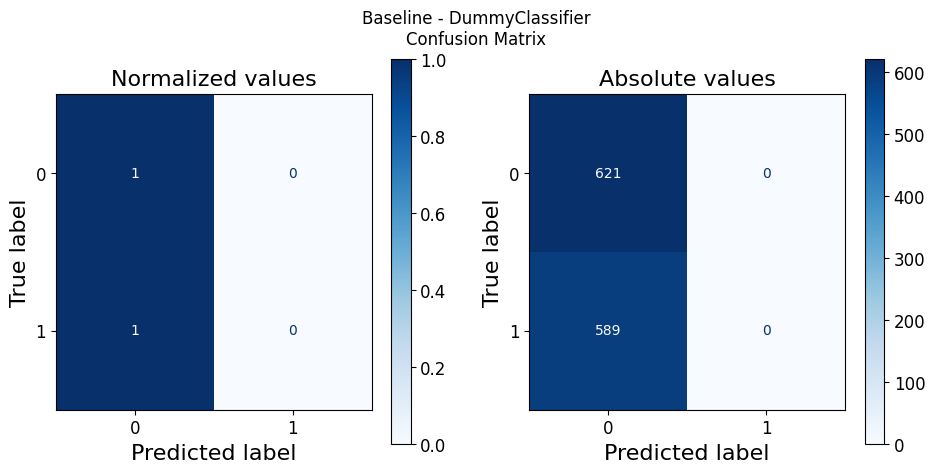

In [5]:
get_baseline(datasets)

## SVC

In [ ]:
svc_0 = BayesianOptimization(
    model=SVC,
    file_name=f"{task}/svc_0", 
    model_params=[
        Real(name="C", low=0.1, high=4.0)
    ],
    fix_model_params={"class_weight": "balanced"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc"
)

svc_0.optimize(n_calls=20) 
svc_0.pretty_results()

In [ ]:
metric_columns = list(svc_0.results.filter(regex='val_'))
# Position 0
best_params_0 = svc_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
svc_0_y_pred, svc_0_y_pred_proba = svc_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], svc_0_y_pred, svc_0.file_loc)

del svc_0

## RandomForestClassifier

For a random forest classifier we don't need to do any preprocessing. A decision tree based classifier is scale invariant and has inbuild feature selection.

In [8]:
x_train = datasets["train"].drop("Y", axis=1)
y_train = datasets["train"]["Y"]
x_val = datasets["val"].drop("Y", axis=1)
y_val = datasets["val"]["Y"]

# drop constant features
preprocessing_pipe = DataPreprocessing(feature_groups, corr_threshold=1.0)
preprocessing_pipe.fit(x_train, y_train)
x_train_preprocessed = preprocessing_pipe.transform(x_train)
x_val_preprocessed = preprocessing_pipe.transform(x_val)

rf_max_depth = train_random_forest_depth(
    f"optimization/{task}/rf_max_depth",
    x_train_preprocessed,
    x_val_preprocessed,
    y_train,
    y_val,
    class_weight="balanced"
)

metric_columns = list(rf_max_depth.filter(regex="val_"))

pretty_print_df(
    rf_max_depth.sort_values("val_mcc", ascending=False), subset=metric_columns, quantile=0.98
)

Completed run 3/60: max_depth=3
Completed run 4/60: max_depth=4
Completed run 5/60: max_depth=5
Completed run 6/60: max_depth=6
Completed run 7/60: max_depth=7
Completed run 8/60: max_depth=8
Completed run 9/60: max_depth=9
Completed run 10/60: max_depth=10
Completed run 11/60: max_depth=11
Completed run 12/60: max_depth=12
Completed run 13/60: max_depth=13
Completed run 14/60: max_depth=14
Completed run 15/60: max_depth=15
Completed run 16/60: max_depth=16
Completed run 17/60: max_depth=17
Completed run 18/60: max_depth=18
Completed run 19/60: max_depth=19
Completed run 20/60: max_depth=20
Completed run 21/60: max_depth=21
Completed run 22/60: max_depth=22
Completed run 23/60: max_depth=23
Completed run 24/60: max_depth=24
Completed run 25/60: max_depth=25
Completed run 26/60: max_depth=26
Completed run 27/60: max_depth=27
Completed run 28/60: max_depth=28
Completed run 29/60: max_depth=29
Completed run 30/60: max_depth=30
Completed run 31/60: max_depth=31
Completed run 32/60: max_dep

,max_depth,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
29,32,0.853719,0.845144,0.871841,0.820034,0.707975,0.933845,0.933317
26,29,0.852893,0.845217,0.866310,0.825127,0.705978,0.930609,0.930638
43,46,0.851240,0.842382,0.869801,0.816638,0.703053,0.933488,0.931311
36,39,0.850413,0.840247,0.875000,0.808149,0.701982,0.930977,0.930294
33,36,0.850413,0.840809,0.872263,0.811545,0.701700,0.932671,0.930988


In [9]:
best_depth = int(rf_max_depth.sort_values("val_mcc", ascending=False).iloc[0]["max_depth"])
best_rf = RandomForestClassifier(max_depth = best_depth, class_weight="balanced", n_jobs=-1)
best_rf.fit(x_train_preprocessed, y_train)
rf_best_y_pred = best_rf.predict(x_val_preprocessed)
rf_best_y_pred_proba = best_rf.predict_proba(x_val_preprocessed)[:,1]

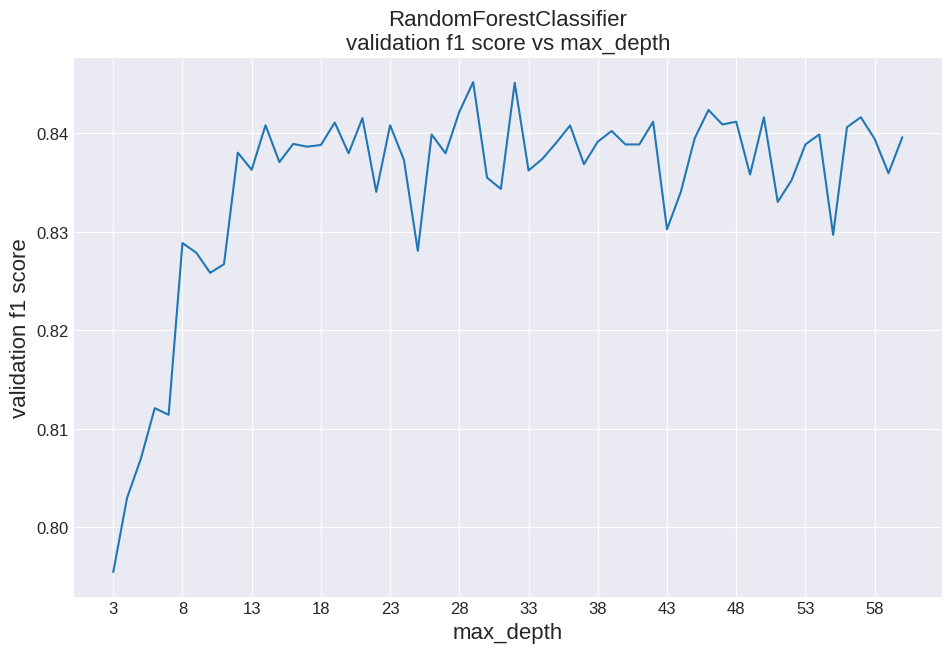

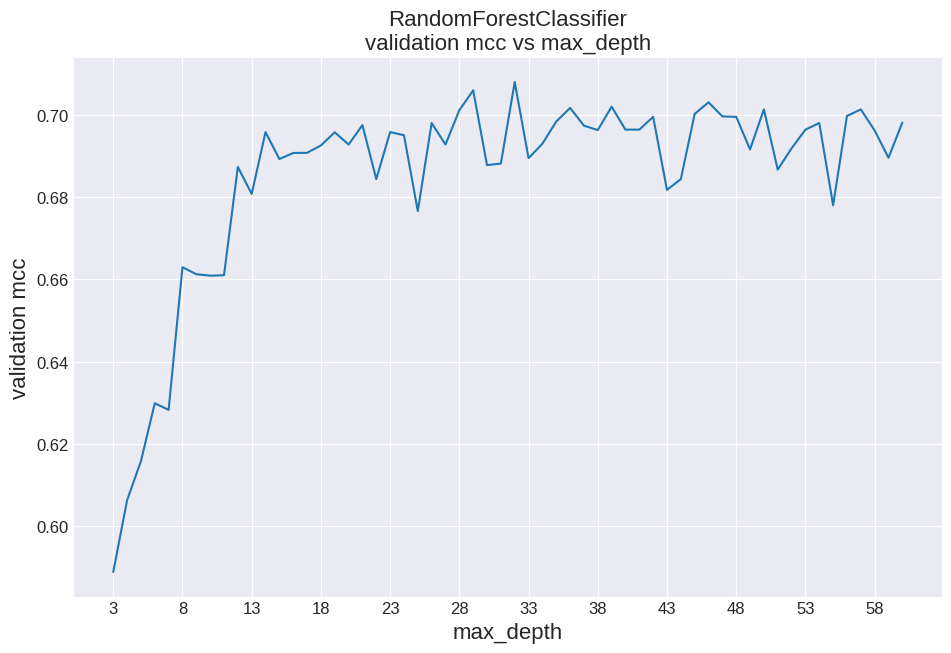

In [10]:
plot_parameter_metric(
    metric_values=rf_max_depth["val_f1"],
    model_name="RandomForestClassifier",
    metric="validation f1 score",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

plot_parameter_metric(
    metric_values=rf_max_depth["val_mcc"],
    model_name="RandomForestClassifier",
    metric="validation mcc",
    parameter="max_depth",
    param_values=rf_max_depth["max_depth"],
)

Accuracy: 84.55%
F1-score: 83.61%
Matthews correlation coefficient: 0.6914917197218725%


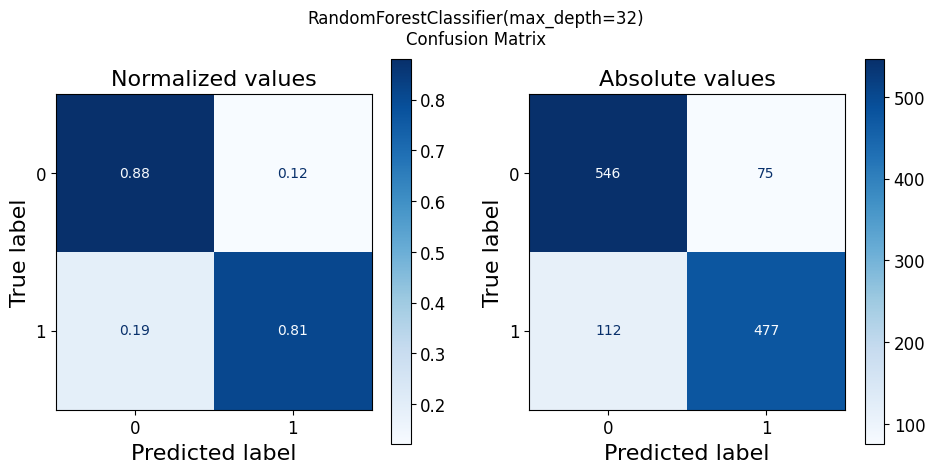

In [11]:
conf_matrix(y_val, rf_best_y_pred, f"RandomForestClassifier(max_depth={best_depth})")

In [ ]:
compare_metric_curves(
    {
        "RandomForestClassifier": rf_best_y_pred_proba
    },
    datasets["val"]["Y"],
)

## Logistic Regression

In [ ]:
lr_0 = BayesianOptimization(
    model=LogisticRegression,
    file_name=f"{task}/lr_0",
    model_params=[
        Real(name="C", low=0.1, high=4.0),
        Real(name="l1_ratio", low=0, high=1),
    ],
    fix_model_params={
        "solver": "saga",
        "n_jobs": -1,
        "class_weight": "balanced",
        "penalty": "elasticnet",
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

lr_0.optimize(n_calls=20)
lr_0.pretty_results()

In [ ]:
metric_columns = list(lr_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = lr_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
lr_0_best_y_pred, lr_0_best_y_pred_proba = lr_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], lr_0_best_y_pred, lr_0.file_loc)

del lr_0 

## CatBoost


In [ ]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

catboost_0 = BayesianOptimization(
    model=CatBoostClassifier,
    file_name=f"{task}/catboost_0",
    model_params=[
        Integer(name="max_depth", low=4, high=12),
        Real(name="l2_leaf_reg", low=2., high=10.),
        # Categorical(name="boosting_type", categories=["Ordered", "Plain"]),
        Real(name="scale_pos_weight",low=max(1,n_negative/n_positive-1), high=6),
    ],
    fix_model_params={
        "verbose": 0,
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

catboost_0.optimize(n_calls=50)
catboost_0.pretty_results(quantile=0.9)

In [ ]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

## KNN

In [ ]:
knn_0 = BayesianOptimization(
    model=KNeighborsClassifier,
    file_name=f"{task}/knn_0", 
    model_params=[
        Integer(name="n_neighbors", low=3, high=60),
    ],
    datasets=datasets,
    feature_groups=feature_groups,
    preprocessing_params=None,
    main_metric="mcc",
    fix_model_params={"weights":"distance"}
)

knn_0.optimize(n_calls=20)
knn_0.pretty_results()

In [ ]:
metric_columns = list(knn_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)

best_params_0 = list(knn_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
knn_0_best_y_pred, knn_0_best_y_pred_proba = knn_0.get_predictions(best_params_0)
conf_matrix(datasets["val"]["Y"], knn_0_best_y_pred, knn_0.file_loc)

del knn_0

## XGBoost

In [12]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

xgboost_0 = BayesianOptimization(
    model=XGBClassifier,
    file_name=f"{task}/xgboost_",
    model_params=[
        Integer(name="max_depth", low=5, high=50),
        Real(name="eta", low=0.01, high=0.2),
        Real(name="subsample", low=0.5, high=1),
        Real(name="scale_pos_weight", low=max(1, n_negative / n_positive - 1), high=6),
        Real(name="colsample_bytree", low=0.5, high=1.0),
        Real(name="lambda", low=0.5, high=4.0),
    ],
    fix_model_params={"objective": "binary:logistic", "eval_metric": "aucpr"},
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

xgboost_0.optimize(n_calls=70)
xgboost_0.pretty_results()

,max_depth,eta,subsample,scale_pos_weight,colsample_bytree,lambda,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
8,43,0.147094,0.846458,4.304004,0.905882,1.107695,0.035264,0.043667,0.008435,0.979899,0.861983,0.862777,0.835987,0.891341,0.725751,0.940255,0.939593
56,46,0.157573,0.842674,4.398773,0.667249,2.364076,0.036406,0.041927,0.000642,0.968642,0.859504,0.861564,0.827856,0.898132,0.721887,0.941709,0.943014
55,47,0.136325,0.795932,2.931153,0.913211,1.640904,0.032101,0.047130,0.009652,0.984075,0.860331,0.860215,0.838710,0.882852,0.721791,0.940821,0.940456
65,21,0.171872,0.836373,3.432091,0.662011,1.090815,0.031046,0.047429,0.009169,0.986006,0.858678,0.857619,0.841503,0.874363,0.717961,0.941250,0.941465
45,19,0.176383,0.890229,3.908913,0.582640,2.163737,0.026188,0.043649,0.009052,0.924609,0.857851,0.858320,0.833600,0.884550,0.717219,0.937934,0.937762


Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
Number of features after preprocessing:             2185/2256
Accuracy: 85.70%
F1-score: 85.88%
Matthews correlation coefficient: 0.716596327302568%


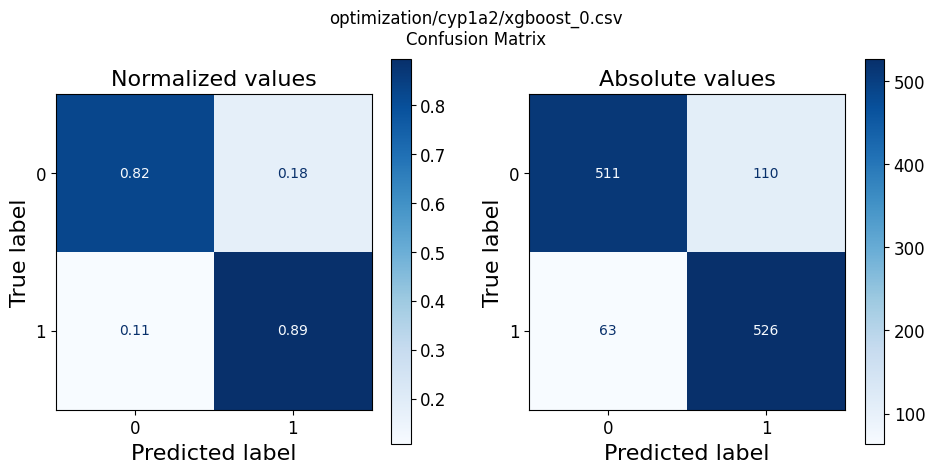

In [13]:
metric_columns = list(xgboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = list(xgboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0])
best_params_0[0] = int(best_params_0[0])
xgboost_0_best_y_pred, xgboost_0_best_y_pred_proba = xgboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], xgboost_0_best_y_pred, xgboost_0.file_loc)

del xgboost_0

In [ ]:
compare_metric_curves(
    {
        "XGBoost" : xgboost_0_best_y_pred_proba
    },
    datasets["val"]["Y"],
)

## Best Model

In [5]:
pd.read_csv(f"optimization/{task}/best.csv", comment="#").sort_values("val_mcc", ascending=False)

,model,val_accuracy,val_f1,val_mcc,false_negative_rate,false_positive_rate
3,CatBoost,0.87,0.87,0.74,0.11,0.15
0,SVC,0.87,0.87,0.73,0.12,0.14
5,XGBoost,0.86,0.86,0.73,0.11,0.17
2,LogisticRegression,0.86,0.85,0.71,0.14,0.15
1,RandomForest,0.84,0.83,0.68,0.20,0.12
4,KNN,0.81,0.80,0.61,0.20,0.19


### CatBoost

In [6]:
n_negative = datasets["train"]["Y"][datasets["train"]["Y"] == 0].count()
n_positive = datasets["train"]["Y"][datasets["train"]["Y"] == 1].count()

catboost_0 = BayesianOptimization(
    model=CatBoostClassifier,
    file_name=f"{task}/catboost_0",
    model_params=[
        Integer(name="max_depth", low=4, high=12),
        Real(name="l2_leaf_reg", low=2., high=10.),
        # Categorical(name="boosting_type", categories=["Ordered", "Plain"]),
        Real(name="scale_pos_weight",low=max(1,n_negative/n_positive-1), high=6),
    ],
    fix_model_params={
        "verbose": 0,
    },
    datasets=datasets,
    feature_groups=feature_groups,
    main_metric="mcc",
)

catboost_0.optimize(n_calls=50)
catboost_0.pretty_results(quantile=0.9)

,max_depth,l2_leaf_reg,scale_pos_weight,var_threshold_continuous,var_threshold_discrete,var_threshold_fingerprint,corr_threshold,val_accuracy,val_f1,val_precision,val_recall,val_mcc,val_roc_auc_score,val_average_precision_score
40,5,2.302131,1.411973,0.045288,0.046431,0.007661,0.842173,0.867769,0.867550,0.846527,0.889643,0.736604,0.939164,0.935871
12,7,2.511163,1.261228,0.047375,0.038814,0.006074,0.826390,0.866116,0.864094,0.854063,0.874363,0.732404,0.941335,0.939190
36,4,7.958573,1.130923,0.049196,0.036651,0.010059,0.894129,0.864463,0.861953,0.854758,0.869270,0.728954,0.936646,0.933671
18,5,3.731181,1.149559,0.010092,0.028681,0.001801,0.947275,0.863636,0.860994,0.854515,0.867572,0.727270,0.934587,0.930225
37,4,8.140448,1.145332,0.041226,0.029329,0.009157,0.841706,0.863636,0.860524,0.856902,0.864177,0.727166,0.937179,0.933447


Filtered metric columns ['val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_mcc', 'val_roc_auc_score', 'val_average_precision_score']
Number of features after preprocessing:             1119/2256
Accuracy: 86.78%
F1-score: 86.75%
Matthews correlation coefficient: 0.7366039844454422%


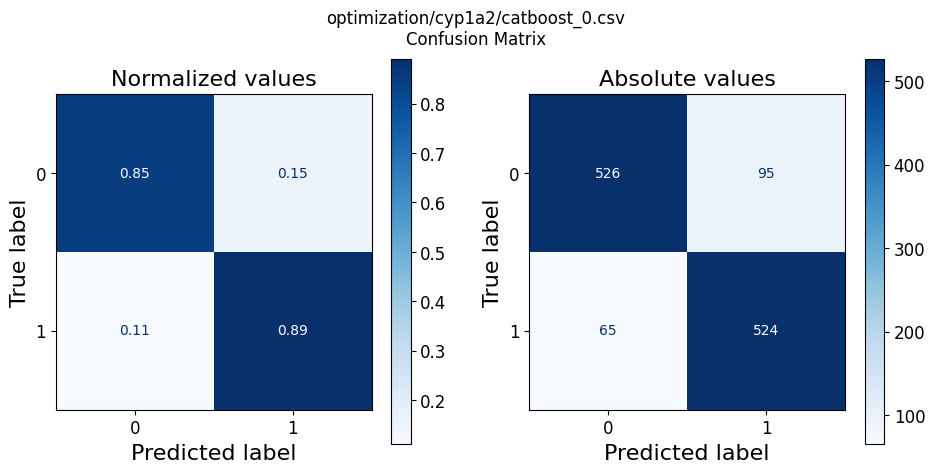

In [8]:
metric_columns = list(catboost_0.results.filter(regex='val_'))
print("Filtered metric columns", metric_columns)
# Position 0
best_params_0 = catboost_0.results.sort_values("val_mcc", ascending=False).drop(metric_columns, axis=1).iloc[0]
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions(best_params_0)

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

In [11]:
list(best_params_0)

[5.0,
 2.302130661080785,
 1.4119732352137206,
 0.0452883422715576,
 0.0464311306167034,
 0.007660577822017,
 0.8421726478843109]

In [19]:
def conf_matrix(y_val, y_pred, model_name):
    """Plot confusion matrix and output different metrics."""
    plt.style.use("default")
    pylab.rcParams.update(PYLAB_PARAMS)
    pylab.rcParams.update({"font.size":14})
    print(f"Accuracy: {accuracy_score(y_val, y_pred)*100:.2f}%")
    print(f"F1-score: {f1_score(y_val, y_pred)*100:.2f}%")
    print(f"Matthews correlation coefficient: {matthews_corrcoef(y_val, y_pred)}%")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*1.6, 5))
   # fig.suptitle(f"{model_name}\nConfusion Matrix")
    ax1.set_title("Normalized values")
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap="Blues", ax=ax1, normalize="true")
    ax2.set_title("Absolute values")
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap="Blues", ax=ax2)
    plt.savefig("final_cyp1a2.svg")
    plt.show()

    
catboost_0_best_y_pred, catboost_0_best_y_pred_proba = catboost_0.get_predictions_test(best_params_0)

conf_matrix(datasets["test"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

In [11]:

conf_matrix(datasets["val"]["Y"], catboost_0_best_y_pred, catboost_0.file_loc)

Number of features after preprocessing:             1119/2256


KeyError: 'fontsize is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

# SHAP

In [5]:
prep = DataPreprocessing(
        feature_groups,
        var_threshold = {"continuous" : 0.0452883422715576, "discrete": 0.0464311306167034, "fingerprint": 0.007660577822017},
        corr_threshold = 0.8421726478843109)

prep.fit(datasets["train"].drop("Y", axis=1), datasets["train"]["Y"])
x_train_preprocessed = prep.transform(datasets["train"].drop("Y", axis=1))

data_norm = MinMaxScaler().fit_transform(datasets["train"].drop("Y", axis=1))
d1 = pd.DataFrame(data_norm, columns=datasets["train"].drop("Y", axis=1).columns)
display(d1)

d2 = pd.DataFrame(x_train_preprocessed )
df = pd.concat([d2, d1], axis=1).T
x_train_prep = df[df.duplicated()].T
display(x_train_prep)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.686888,0.364905,0.686888,0.016428,0.829787,0.341772,0.349405,0.341581,0.296552,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.675797,0.782995,0.675797,0.045717,0.877211,0.377583,0.369058,0.377554,0.386207,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.765714,0.268667,0.765714,0.005720,0.747333,0.430347,0.449310,0.430286,0.386207,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.782936,0.385972,0.782936,0.010471,0.848502,0.486184,0.487430,0.486053,0.462069,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.768939,0.684786,0.768939,0.024953,0.501540,0.517929,0.509852,0.517928,0.531034,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,0.748667,0.789873,0.748667,0.018939,0.235680,0.578869,0.588871,0.578724,0.537931,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8466,0.692198,0.788837,0.692198,0.032125,0.940588,0.321850,0.323954,0.321838,0.317241,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8467,0.326556,0.785565,0.326556,0.010881,0.518898,0.319193,0.323965,0.319199,0.310345,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8468,0.802987,0.710895,0.802987,0.005969,0.452197,0.464925,0.464814,0.464900,0.462069,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,104,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,MolWt,NumValenceElectrons,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,...,2033,2034,2035,2038,2040,2041,2042,2043,2044,2046
0,0.0,0.686888,0.364905,0.686888,0.016428,0.341772,0.296552,0.720034,0.162122,0.115302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.675797,0.782995,0.675797,0.045717,0.377583,0.386207,0.725805,0.023259,0.061651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.765714,0.268667,0.765714,0.005720,0.430347,0.386207,0.717274,0.161237,0.108909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.782936,0.385972,0.782936,0.010471,0.486184,0.462069,0.702793,0.162122,0.108884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.768939,0.684786,0.768939,0.024953,0.517929,0.531034,0.752869,0.024025,0.042324,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8465,0.0,0.748667,0.789873,0.748667,0.018939,0.578869,0.537931,0.714905,0.161530,0.107275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8466,0.0,0.692198,0.788837,0.692198,0.032125,0.321850,0.317241,0.737853,0.022636,0.141049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8467,0.0,0.326556,0.785565,0.326556,0.010881,0.319193,0.310345,0.794652,0.022583,0.128237,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8468,0.0,0.802987,0.710895,0.802987,0.005969,0.464925,0.462069,0.929285,0.023333,0.033912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
model = CatBoostClassifier(
        max_depth=5,
        l2_leaf_reg=2.302131,
        scale_pos_weight=1.411973)

model.fit(x_train_prep, datasets["train"]["Y"])

0:	learn: 0.6783369	total: 77.5ms	remaining: 1m 17s
1:	learn: 0.6659720	total: 105ms	remaining: 52.2s
2:	learn: 0.6517505	total: 126ms	remaining: 41.8s
3:	learn: 0.6403913	total: 143ms	remaining: 35.7s
4:	learn: 0.6282689	total: 162ms	remaining: 32.2s
5:	learn: 0.6184563	total: 180ms	remaining: 29.9s
6:	learn: 0.6093421	total: 199ms	remaining: 28.3s
7:	learn: 0.5991192	total: 214ms	remaining: 26.5s
8:	learn: 0.5908152	total: 228ms	remaining: 25.1s
9:	learn: 0.5816984	total: 242ms	remaining: 24s
10:	learn: 0.5731627	total: 256ms	remaining: 23s
11:	learn: 0.5646951	total: 270ms	remaining: 22.2s
12:	learn: 0.5575202	total: 285ms	remaining: 21.6s
13:	learn: 0.5513029	total: 300ms	remaining: 21.1s
14:	learn: 0.5442439	total: 315ms	remaining: 20.7s
15:	learn: 0.5380078	total: 331ms	remaining: 20.3s
16:	learn: 0.5318889	total: 346ms	remaining: 20s
17:	learn: 0.5265232	total: 359ms	remaining: 19.6s
18:	learn: 0.5209626	total: 372ms	remaining: 19.2s
19:	learn: 0.5155172	total: 386ms	remaining: 

In [7]:
import shap
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_prep)


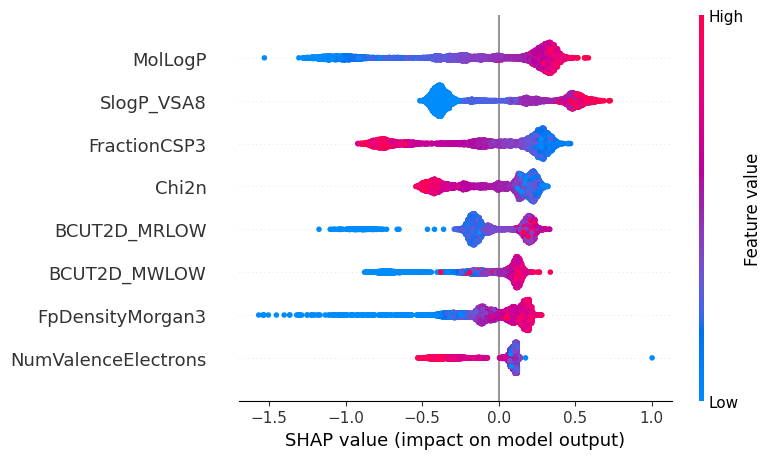

In [8]:

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

fig = shap.summary_plot(shap_values, x_train_prep, show=False, max_display=8)
plt.savefig('1a2_shap_default.svg')
plt.show()

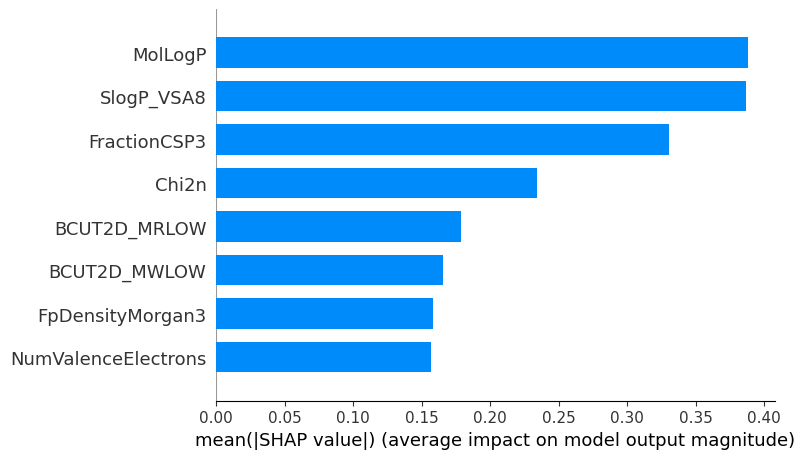

In [9]:
fig = shap.summary_plot(shap_values, x_train_prep, plot_type="bar", show=False, max_display=8)
plt.savefig('1a2_shap_bar.svg')
plt.show()